In [1]:
import os
import numpy as np
import wfdb
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
    confusion_matrix
)
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import random
import pandas as pd
import pickle
from ecgdetectors import Detectors

In [2]:
import matplotlib.pyplot as plt
def plot_ecg_with_peaks(ecg, r_peaks, q_peaks, s_peaks, t_peaks, start=0, end=1000, title='ECG'):
    plt.figure(figsize=(15, 4))
    plt.plot(ecg[start:end], label='ECG')

    # Adjust peak indices to local window
    for peaks, label in zip([r_peaks, q_peaks, s_peaks, t_peaks], ['R', 'Q', 'S', 'T']):
        local_peaks = peaks[(peaks >= start) & (peaks < end)]
        relative_peaks = local_peaks - start  # shift to local view
        plt.scatter(relative_peaks, ecg[local_peaks], label=label)

    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_r_peaks(ecg, r_peaks, start=0, end=1000, title='ECG with R-peaks'):
    plt.figure(figsize=(15, 4))
    plt.plot(ecg[start:end], label='ECG Signal')
    
    # Mask to plot only R peaks in the selected window
    r_visible = r_peaks[(r_peaks >= start) & (r_peaks < end)]
    plt.scatter(r_visible, ecg[r_visible], color='red', label='R Peaks', zorder=3)
    
    plt.title(title)
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_pqrst_peaks(ecg, r_peaks, q_peaks=None, s_peaks=None, p_peaks=None, t_peaks=None, start=0, end=1000, title='ECG with PQRST peaks'):
    plt.figure(figsize=(15, 4))
    plt.plot(ecg[start:end], label='ECG Signal', color='black')

    # Helper function to plot visible peaks within the range
    def plot_peaks(peaks, label, color):
        if peaks is not None:
            visible = peaks[(peaks >= start) & (peaks < end)]
            plt.scatter(visible, ecg[visible], label=label, color=color, zorder=3)

    plot_peaks(p_peaks, 'P Peaks', 'orange')
    plot_peaks(q_peaks, 'Q Peaks', 'blue')
    plot_peaks(r_peaks, 'R Peaks', 'red')
    plot_peaks(s_peaks, 'S Peaks', 'green')
    plot_peaks(t_peaks, 'T Peaks', 'purple')

    plt.title(title)
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# plot_ecg_with_peaks(ecg, r_peaks, q_peaks, s_peaks, t_peaks, start=ann_samples[100], end=ann_samples[100]+500)


In [3]:
def calc_rr(r_peaks, fs):
    return np.diff(r_peaks) / fs

def calc_qs(q_peaks, s_peaks, fs):
    return (s_peaks[:len(q_peaks)] - q_peaks[:len(s_peaks)]) / fs


In [4]:
def extract_features(ecg, ann, r_peaks, q_peaks, s_peaks, t_peaks, fs, comments):
    features_by_class = {'VT': [], 'N': []}
    rr_intervals = calc_rr(r_peaks, fs)
    qs_intervals = calc_qs(q_peaks, s_peaks, fs)
    
    rhythm = comments[0]
    count = 0
    while count < len(ann):
        if comments[count].startswith("("):
            rhythm = comments[count]
        comments[count] = rhythm
        count += 1
    
    count = 0
    while count < len(comments):
        rhythm = comments[count]
        if rhythm in ['(VT', '(N']:
            label = 'VT' if rhythm == '(VT' else 'N'
            start = ann[count]
            while count < len(comments) and comments[count] == rhythm:
                count += 1
            end = ann[count] if count < len(ann) else len(ecg)
            
            r_in = (r_peaks > start) & (r_peaks < end)
            q_in = (q_peaks > start) & (q_peaks < end)
            s_in = (s_peaks > start) & (s_peaks < end)
            t_in = (t_peaks > start) & (t_peaks < end)
            
            n_obs = min(np.sum(r_in), np.sum(q_in), np.sum(s_in), np.sum(t_in))
            for i in range(n_obs):
                feature_vector = [
                    ecg[r_peaks[r_in]][i],
                    ecg[q_peaks[q_in]][i],
                    ecg[s_peaks[s_in]][i],
                    ecg[t_peaks[t_in]][i],
                    rr_intervals[i] if i < len(rr_intervals) else 0,
                    qs_intervals[i] if i < len(qs_intervals) else 0
                ]
                features_by_class[label].append(feature_vector)
        else:
            count += 1
    return features_by_class

In [5]:
folder = 'databases/'
file_list = sorted([f for f in os.listdir(folder) if f.endswith('.hea')])
all_features = {'VT': [], 'N': []}


Processing the ECG: databases/cu01
ecg: 127232 [-0.2725 -0.3075 -0.2975 ...  0.285   0.3275  0.335 ]
r_peaks: 268
Plotting ECG segment with peaks...


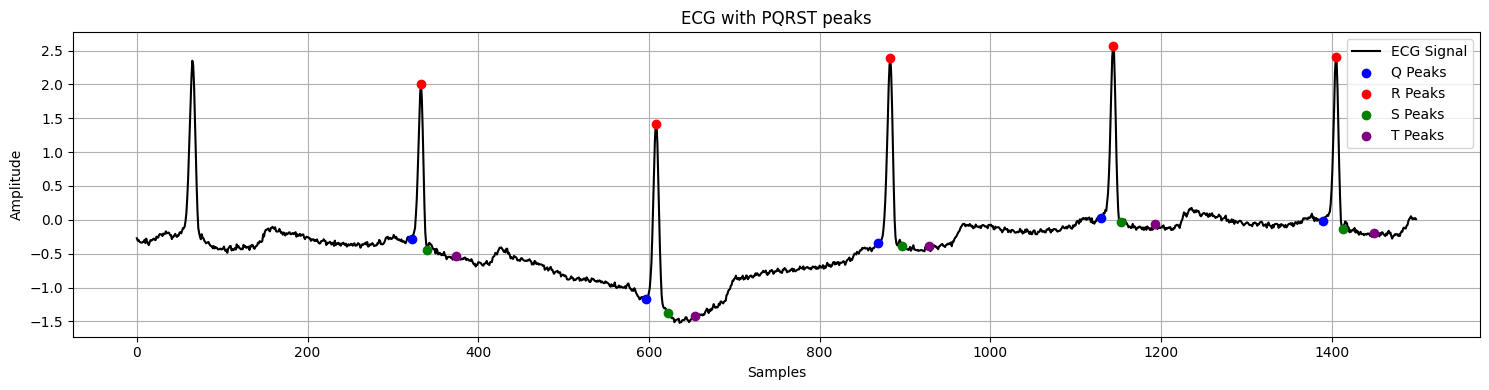

Processing the ECG: databases/cu02
ecg: 127232 [-0.51  -0.52  -0.515 ... -0.08  -0.1   -0.145]


/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 538 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


r_peaks: 806
Plotting ECG segment with peaks...


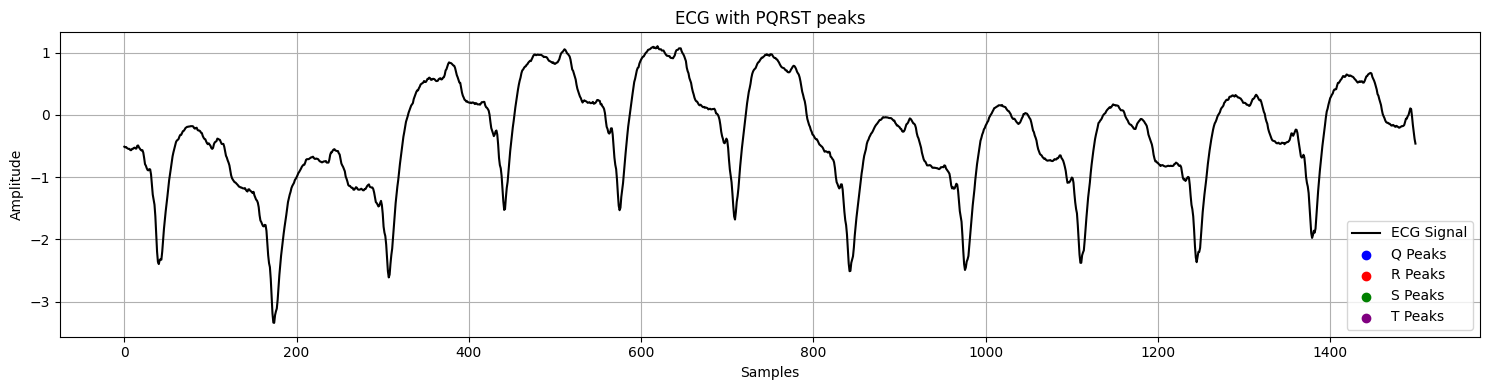

Processing the ECG: databases/cu03
ecg: 127232 [-0.025 -0.08  -0.125 ...  1.06   1.035  0.99 ]


/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 4 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


r_peaks: 937
Plotting ECG segment with peaks...


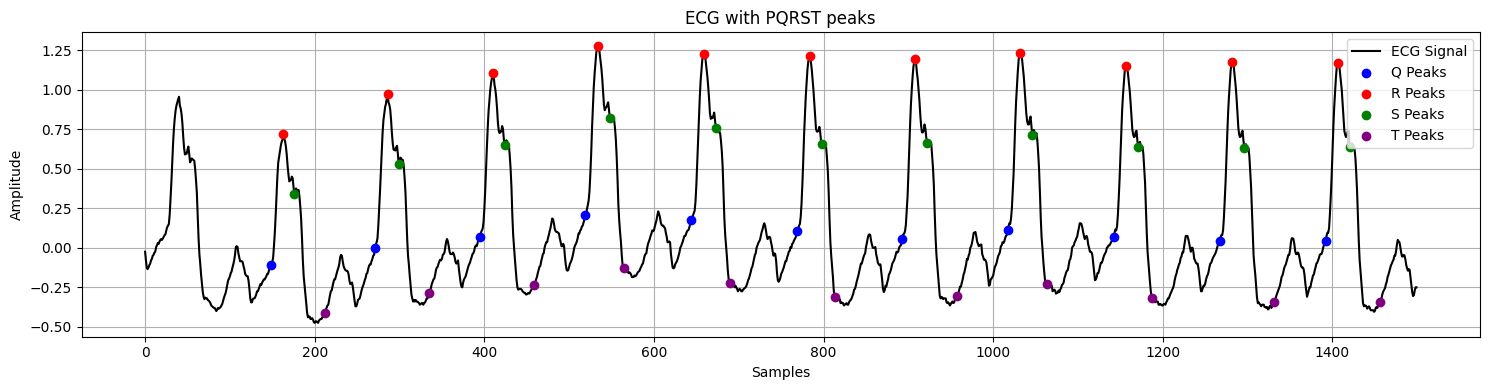

Processing the ECG: databases/cu04
ecg: 127232 [ 0.06    0.0525  0.0475 ... -0.26   -0.26   -0.2575]
r_peaks: 291
Plotting ECG segment with peaks...


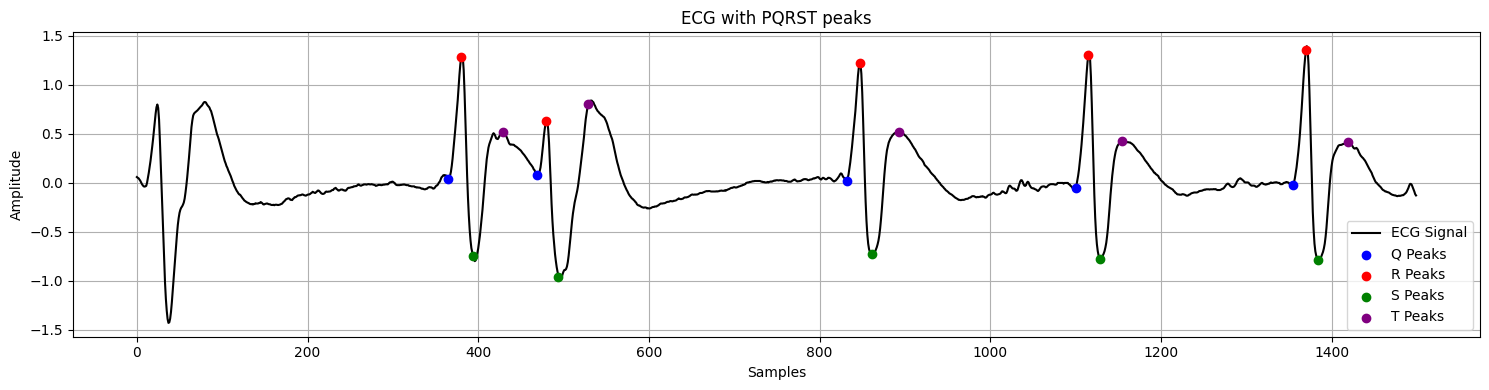

Processing the ECG: databases/cu05
ecg: 127232 [0.17   0.165  0.165  ... 0.045  0.035  0.0275]


/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 52 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


r_peaks: 573
Plotting ECG segment with peaks...


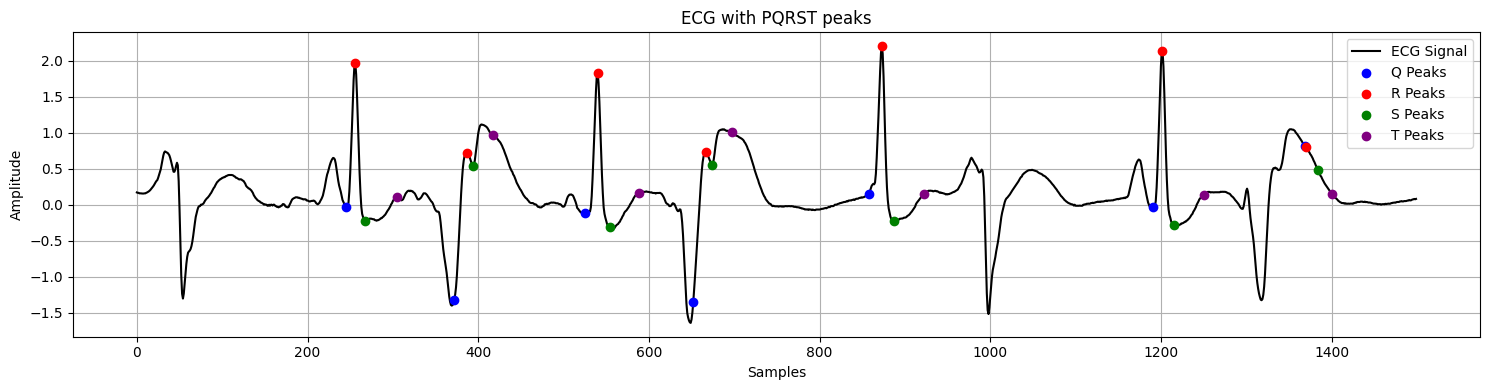

Processing the ECG: databases/cu06
ecg: 127232 [-0.175  -0.18   -0.18   ...  0.59    0.5925  0.585 ]


/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 62 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


r_peaks: 443
Plotting ECG segment with peaks...


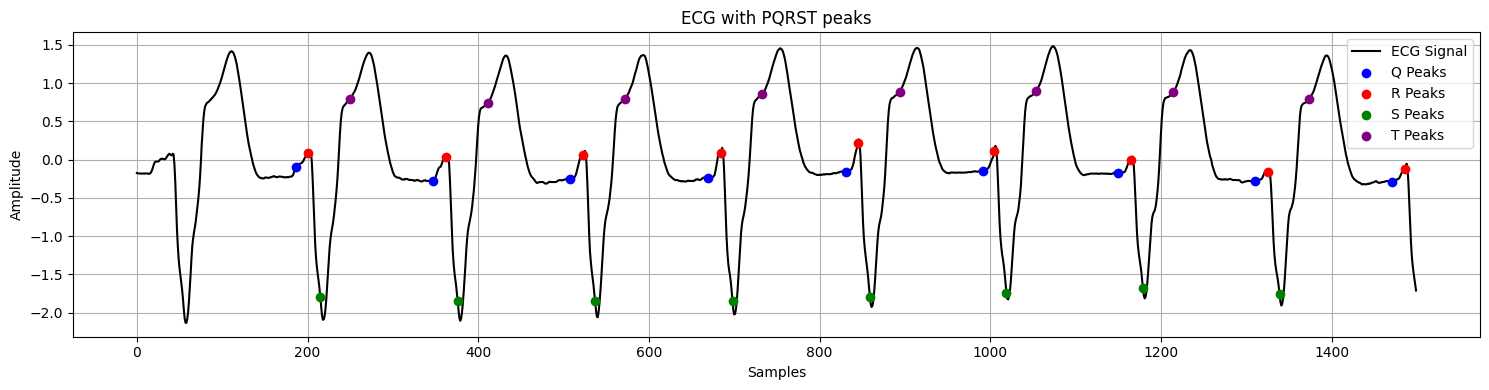

Processing the ECG: databases/cu07
ecg: 127232 [0.1625 0.175  0.18   ... 0.125  0.115  0.0925]
r_peaks: 503
Plotting ECG segment with peaks...


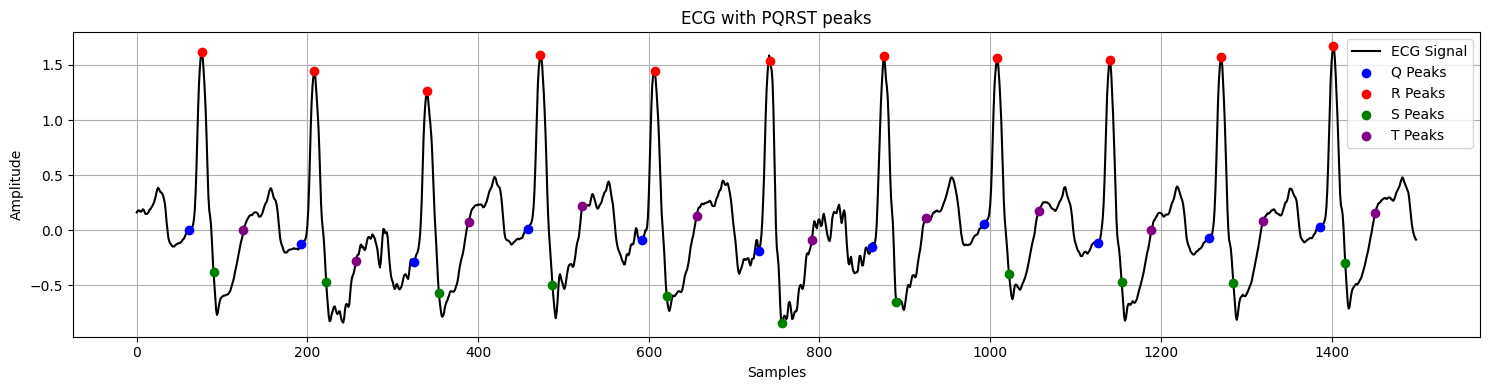

Processing the ECG: databases/cu08
ecg: 127232 [1.6    1.625  1.6375 ... 1.5375 1.5125 1.475 ]


/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 496 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


r_peaks: 1217
Plotting ECG segment with peaks...


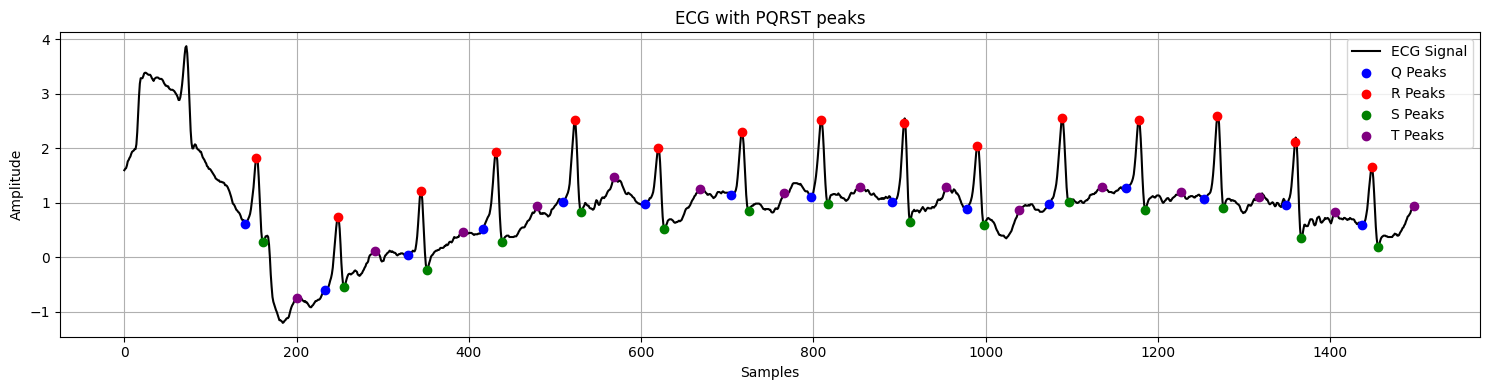

Processing the ECG: databases/cu09
ecg: 127232 [1.555 1.575 1.62  ... 0.82  0.79  0.715]


/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 1099 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


r_peaks: 647
Plotting ECG segment with peaks...


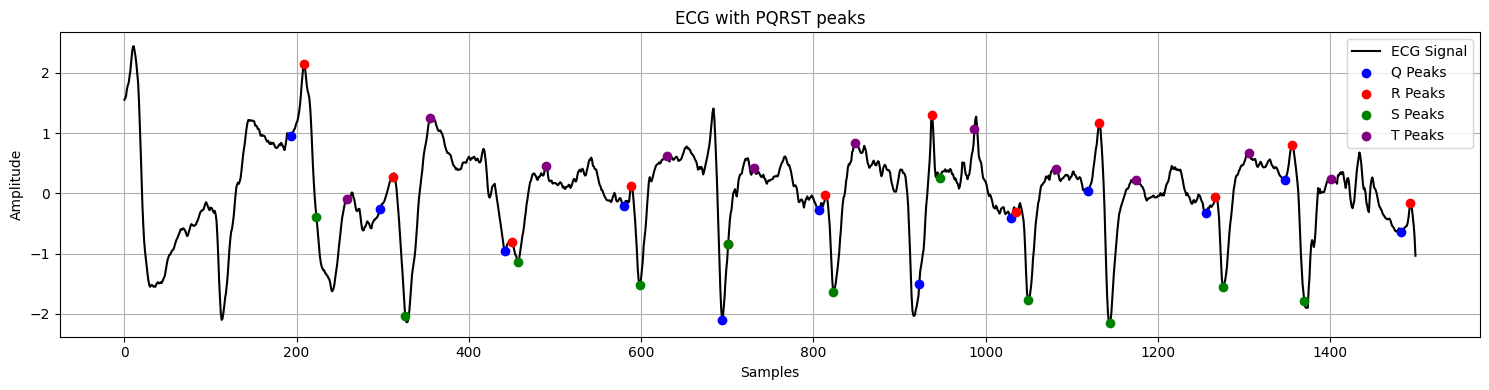

Processing the ECG: databases/cu10
ecg: 127232 [ 0.1725  0.2125  0.265  ... -0.9925 -1.1275 -1.24  ]


/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 453 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


r_peaks: 591
Plotting ECG segment with peaks...


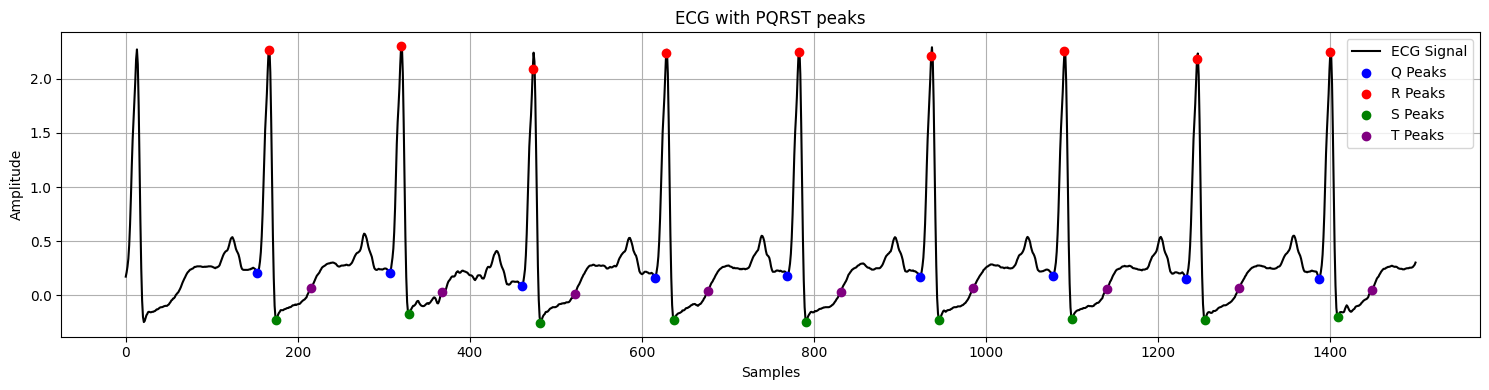

Processing the ECG: databases/cu11
ecg: 127232 [0.345  0.345  0.3375 ... 1.275  1.17   1.02  ]


/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 1282 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


r_peaks: 580
Plotting ECG segment with peaks...


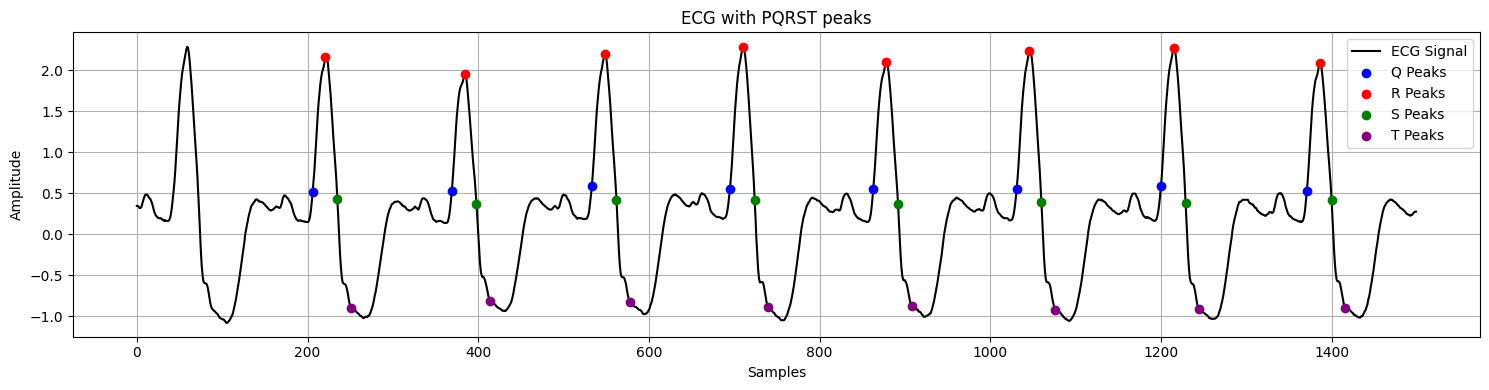

Processing the ECG: databases/cu12
ecg: 127232 [0.2575 0.24   0.205  ... 1.795  1.8725 1.9425]


/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 271 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


r_peaks: 135
Plotting ECG segment with peaks...


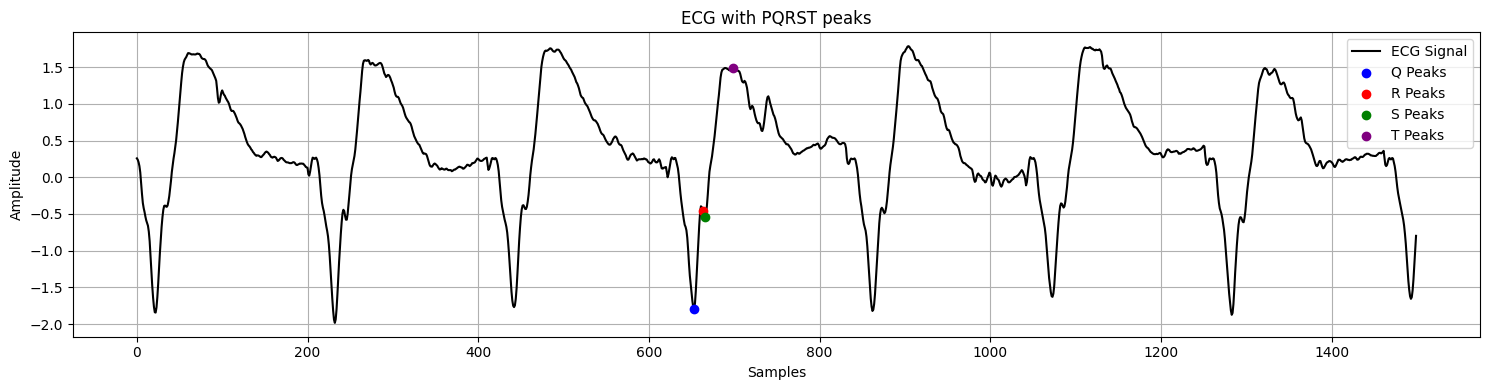

Processing the ECG: databases/cu13
ecg: 127232 [ 0.09    0.0975  0.1025 ... -0.025   0.01    0.03  ]


/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 338 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


r_peaks: 746
Plotting ECG segment with peaks...


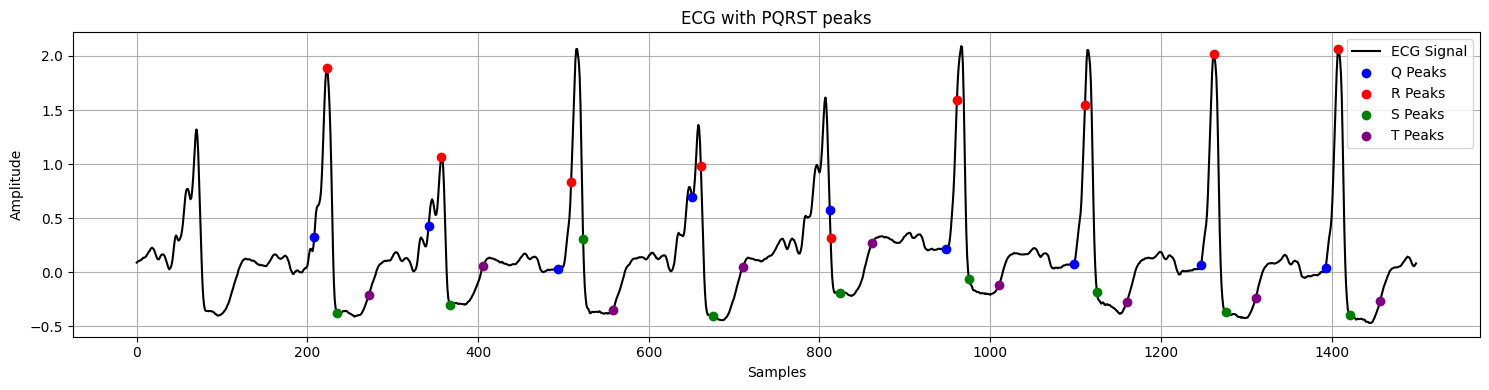

Processing the ECG: databases/cu14
ecg: 127232 [-0.235 -0.365 -0.44  ...  1.33   1.415  1.48 ]


/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 14 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


r_peaks: 467
Plotting ECG segment with peaks...


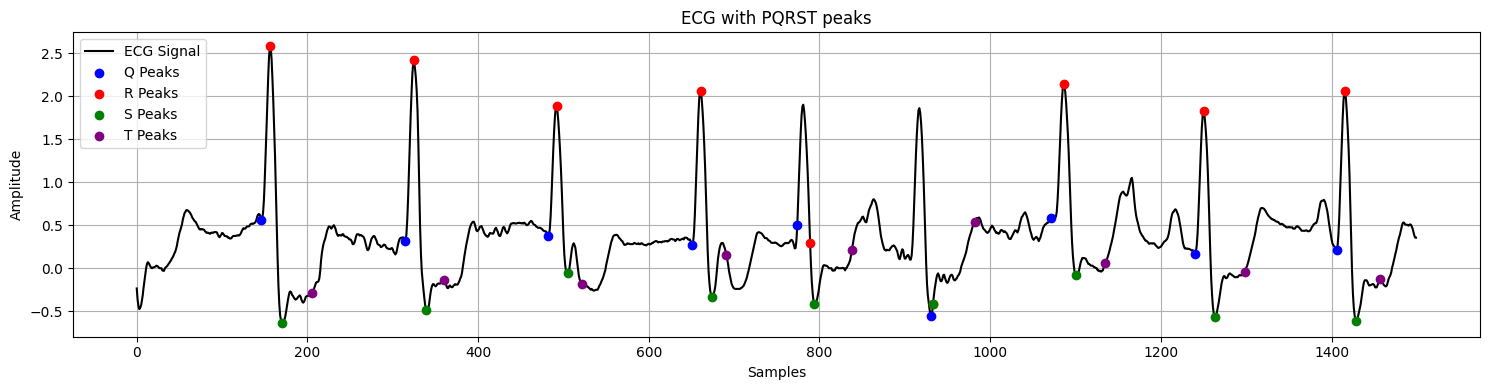

Processing the ECG: databases/cu15
ecg: 127232 [ 0.4025  0.18   -0.3725 ...  0.3475  0.35    0.3875]
r_peaks: 300
Plotting ECG segment with peaks...


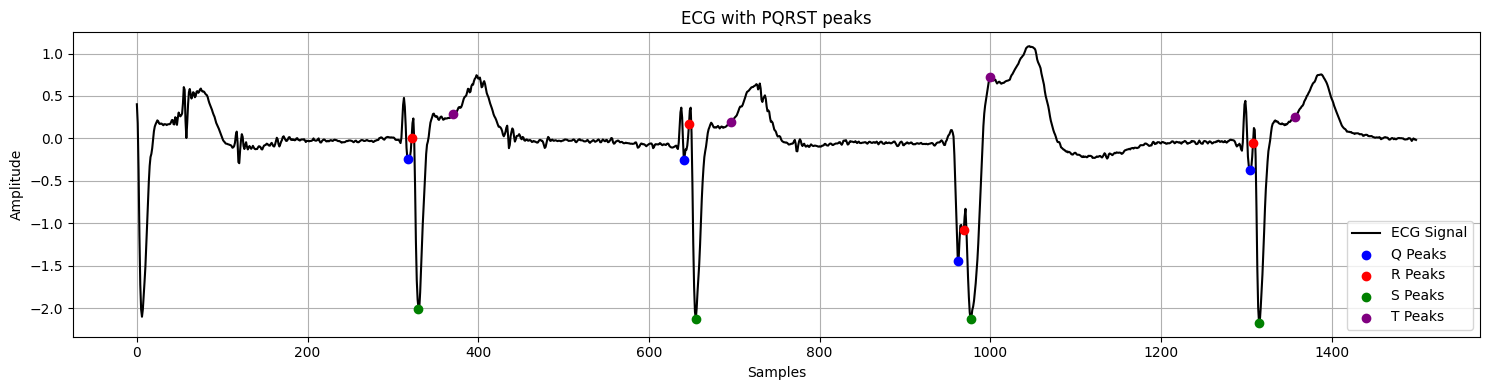

Processing the ECG: databases/cu16
ecg: 127232 [-0.0725  0.0025  0.1225 ... -0.9    -1.1575 -1.265 ]


/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 79 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


r_peaks: 652
Plotting ECG segment with peaks...


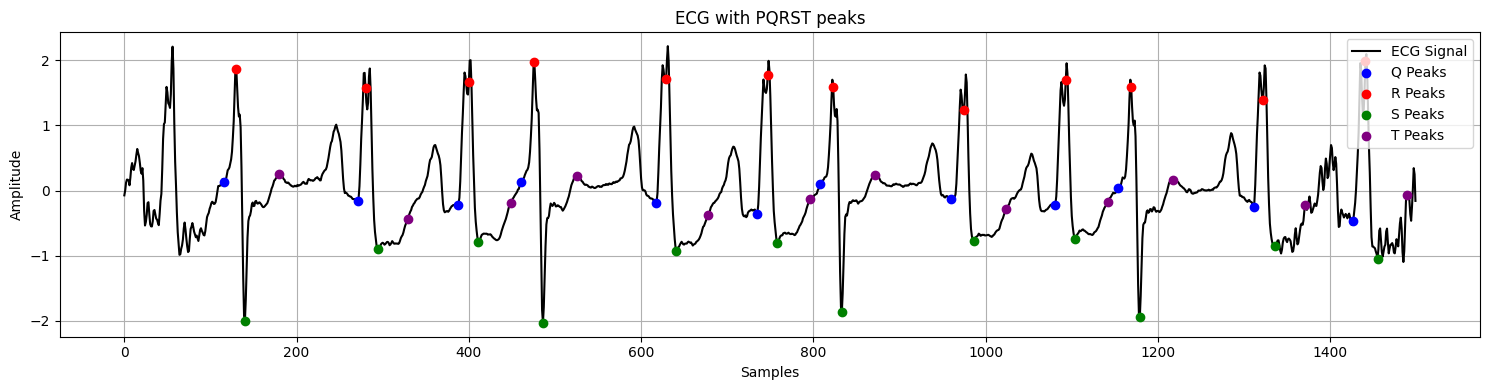

Processing the ECG: databases/cu17
ecg: 127232 [-0.0475 -0.0525 -0.045  ...  0.0025  0.      0.0075]


/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 683 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


r_peaks: 560
Plotting ECG segment with peaks...


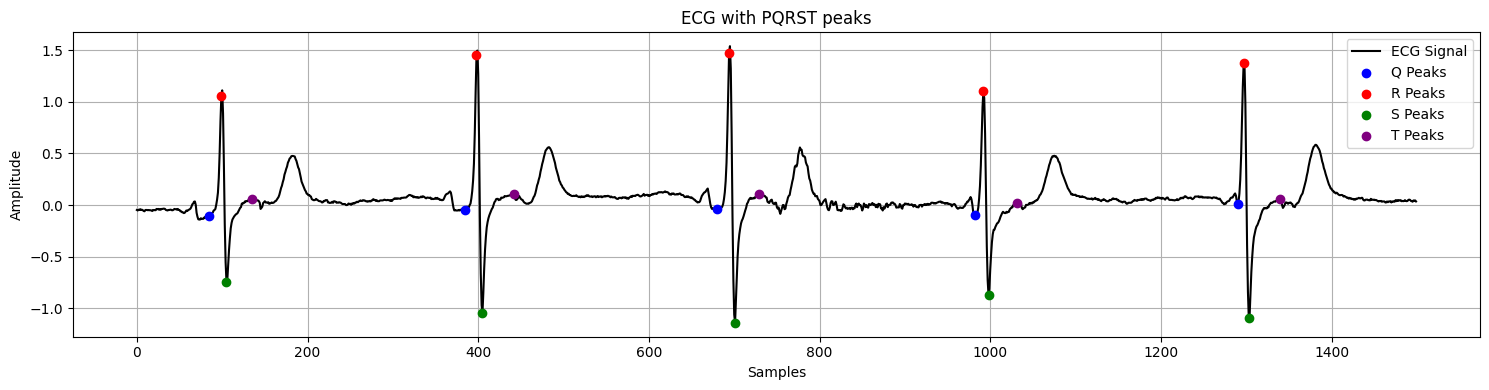

Processing the ECG: databases/cu18
ecg: 127232 [-0.2525 -0.2375 -0.21   ... -0.4925 -0.6    -0.575 ]
r_peaks: 683
Plotting ECG segment with peaks...


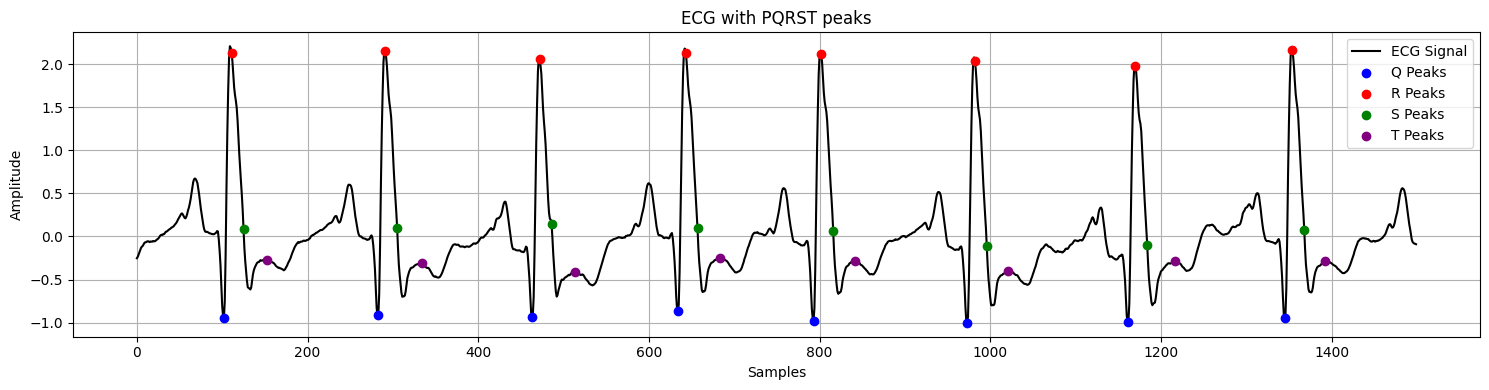

Processing the ECG: databases/cu19
ecg: 127232 [ 0.2525  0.14    0.08   ... -2.21   -2.16   -1.865 ]


/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 1605 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


r_peaks: 688
Plotting ECG segment with peaks...


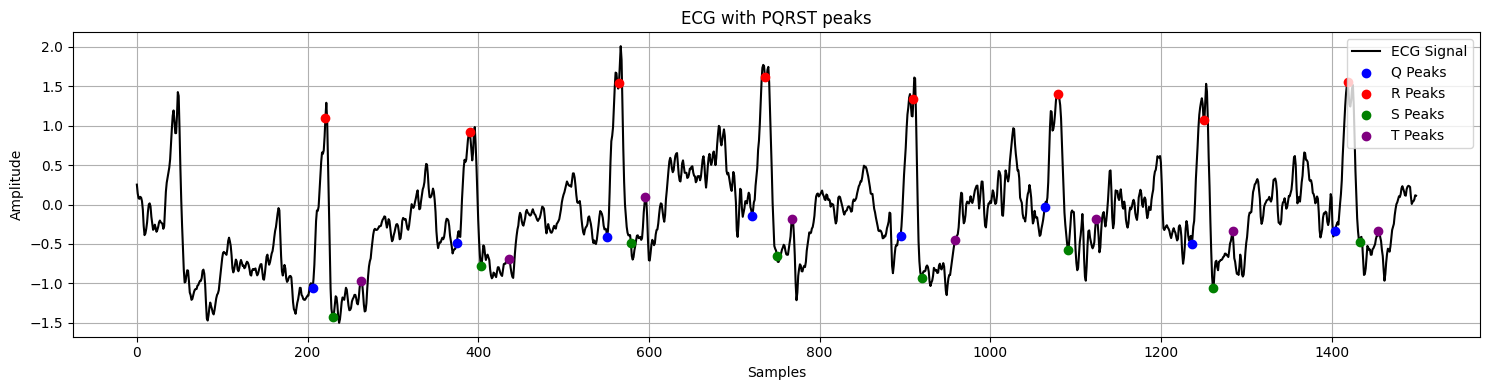

Processing the ECG: databases/cu20
ecg: 127232 [-0.05    0.0125  0.025  ... -1.06   -1.0475 -1.045 ]


/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 1635 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


r_peaks: 299
Plotting ECG segment with peaks...


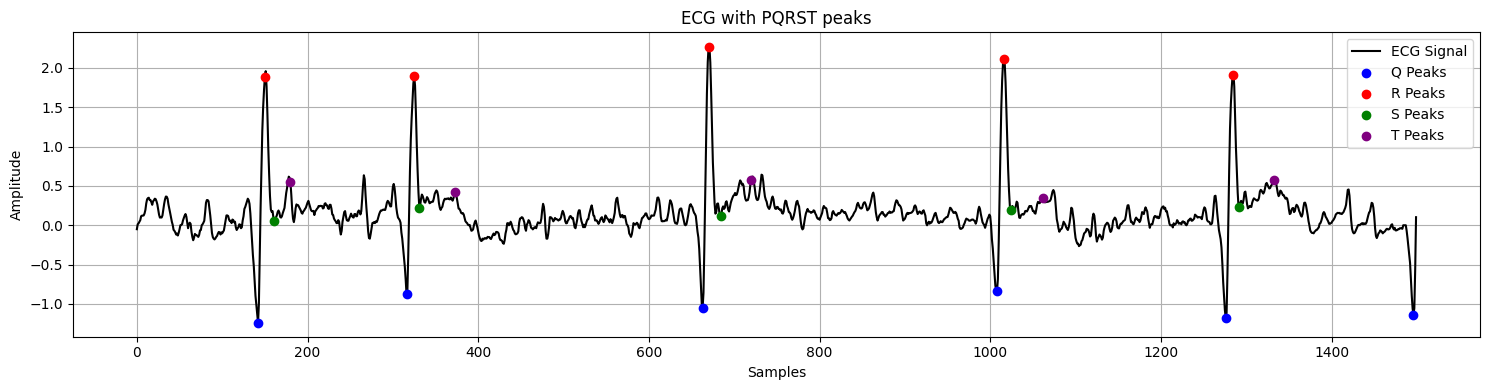

Processing the ECG: databases/cu21
ecg: 127232 [-1.3625 -1.61   -1.945  ... -0.15   -0.12   -0.1075]


/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 2146 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


r_peaks: 563
Plotting ECG segment with peaks...


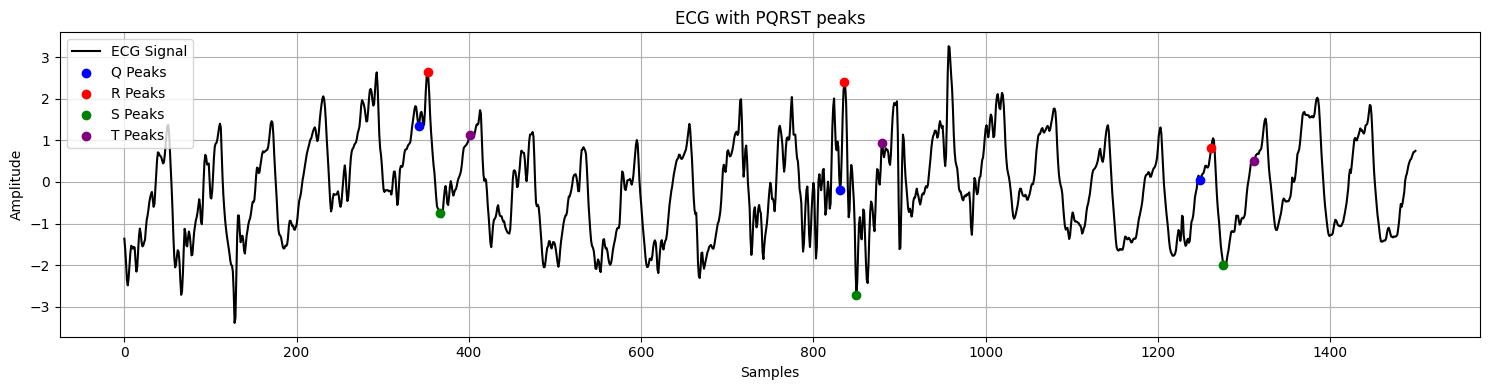

Processing the ECG: databases/cu22
ecg: 127232 [ 0.06   0.06   0.05  ... -0.45  -0.46  -0.445]


/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 1018 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


r_peaks: 467
Plotting ECG segment with peaks...


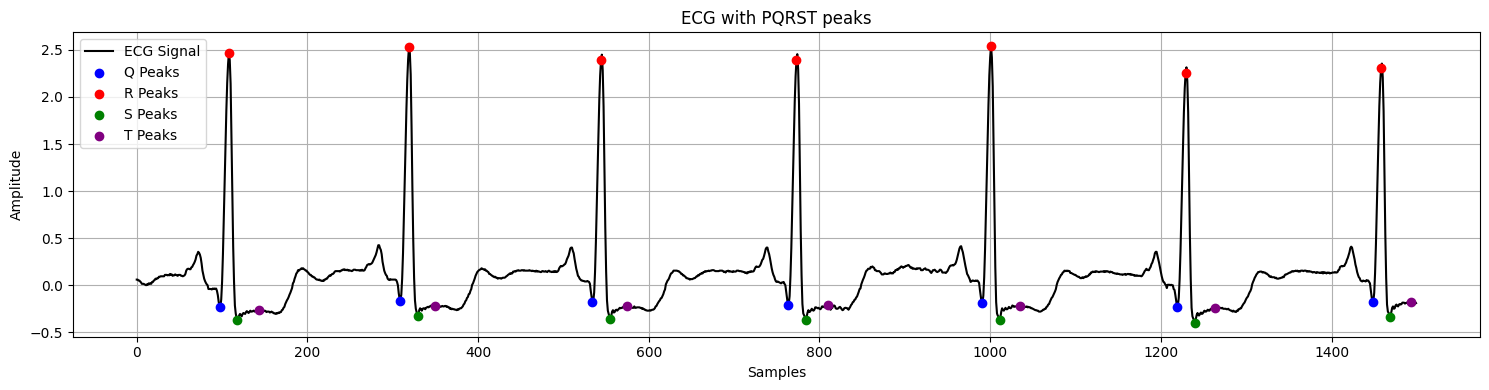

Processing the ECG: databases/cu23
ecg: 127232 [-0.215 -0.2   -0.18  ... -0.095 -0.045  0.01 ]


/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 2416 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


r_peaks: 495
Plotting ECG segment with peaks...


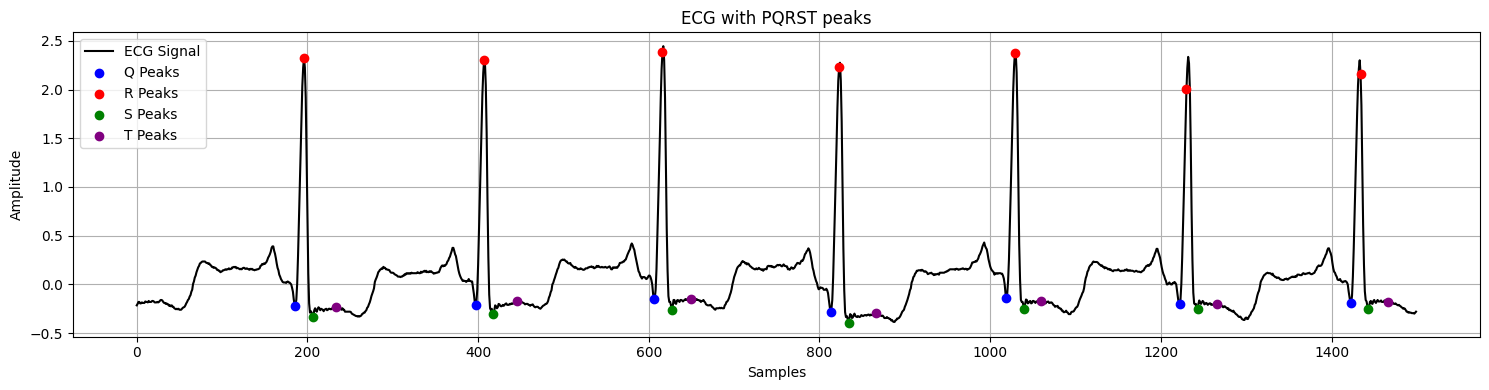

Processing the ECG: databases/cu24
ecg: 127232 [1.205  1.53   1.845  ... 0.1075 0.11   0.105 ]


/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 2320 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


r_peaks: 572
Plotting ECG segment with peaks...


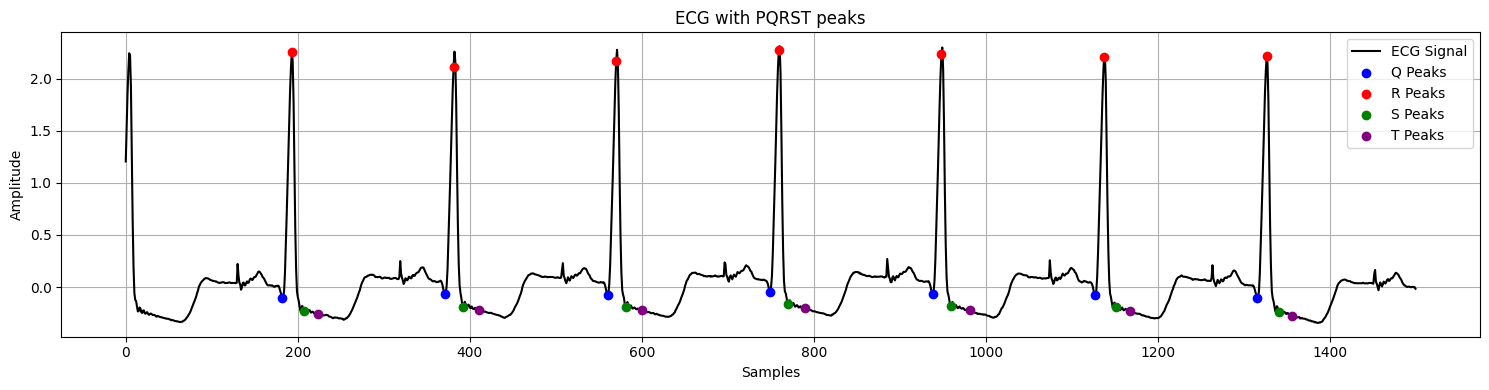

Processing the ECG: databases/cu25
ecg: 127232 [0.31   0.13   0.0475 ... 0.47   0.47   0.47  ]


/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 150 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


r_peaks: 558
Plotting ECG segment with peaks...


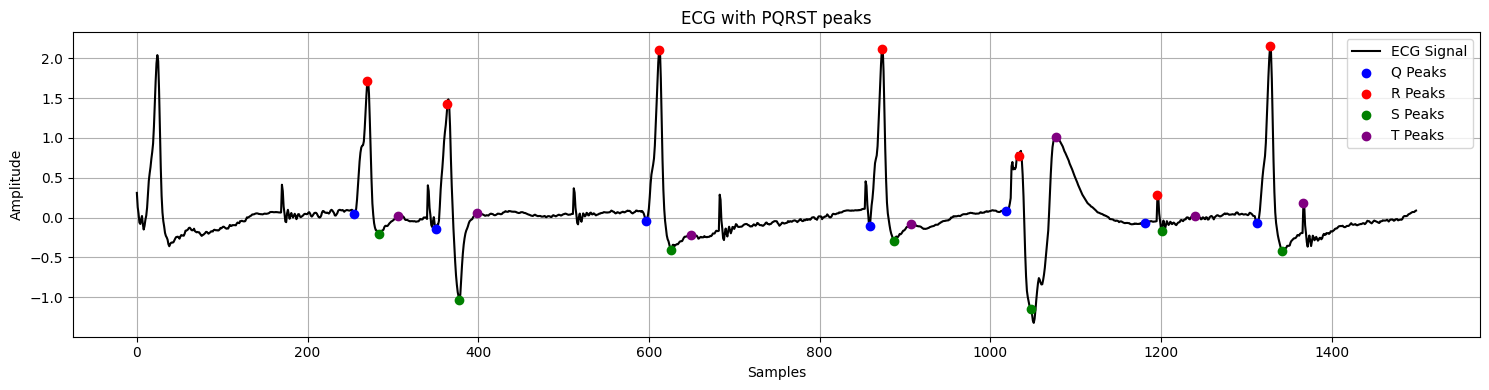

Processing the ECG: databases/cu26
ecg: 127232 [-0.18   -0.1625 -0.1525 ... -0.7425 -0.7825 -0.76  ]


/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 7368 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


r_peaks: 760
Plotting ECG segment with peaks...


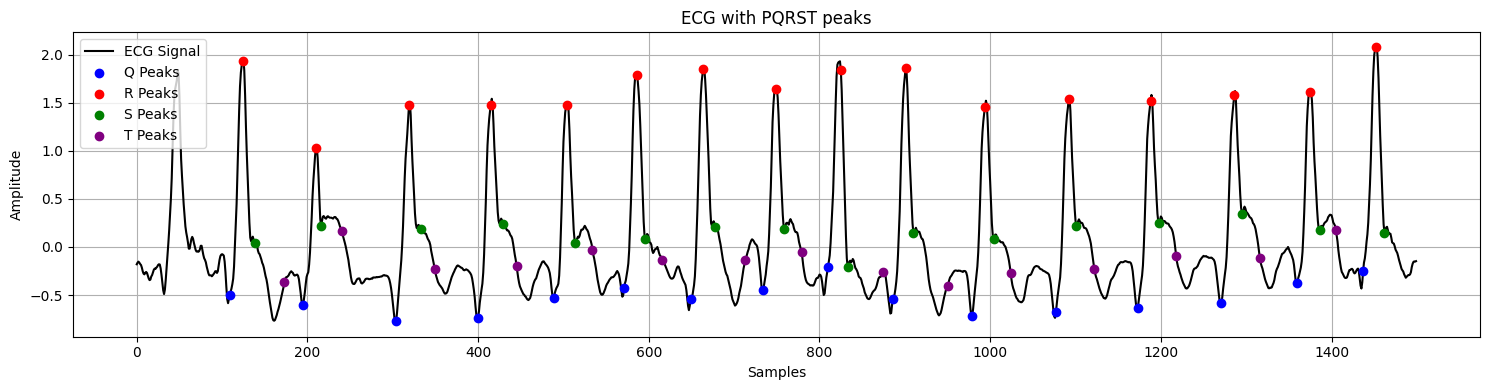

Processing the ECG: databases/cu27
ecg: 127232 [    nan     nan     nan ... -0.2625 -0.3075 -0.335 ]
Skipping databases/cu27: integer division or modulo by zero
Processing the ECG: databases/cu28
ecg: 127232 [-0.4325 -0.325  -0.1325 ... -0.1675 -0.18   -0.1775]


/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 2278 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))
/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


r_peaks: 421
Plotting ECG segment with peaks...


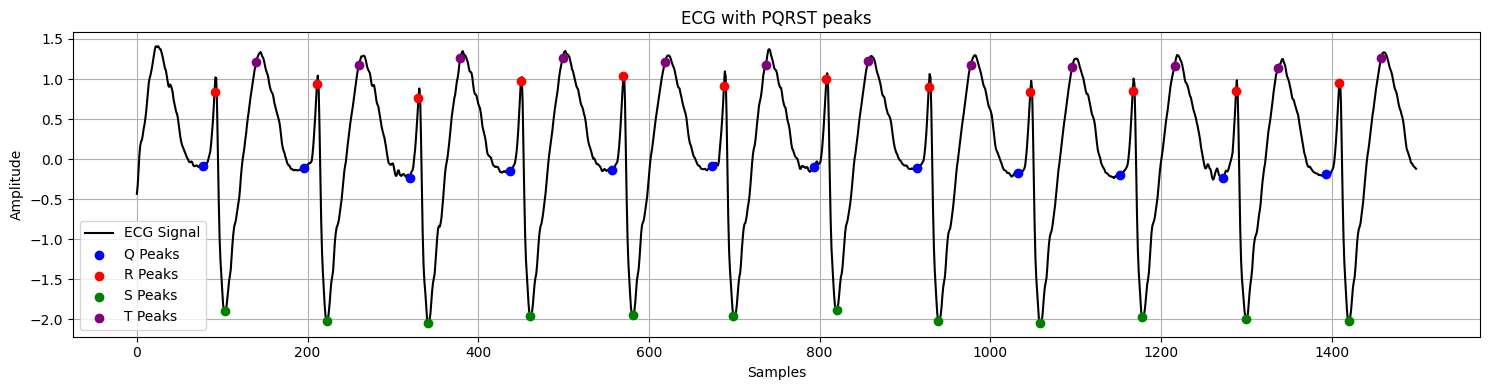

Processing the ECG: databases/cu29
ecg: 127232 [0.085  0.1675 0.34   ... 5.1175 5.1175 5.1175]


/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 888 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


r_peaks: 572
Plotting ECG segment with peaks...


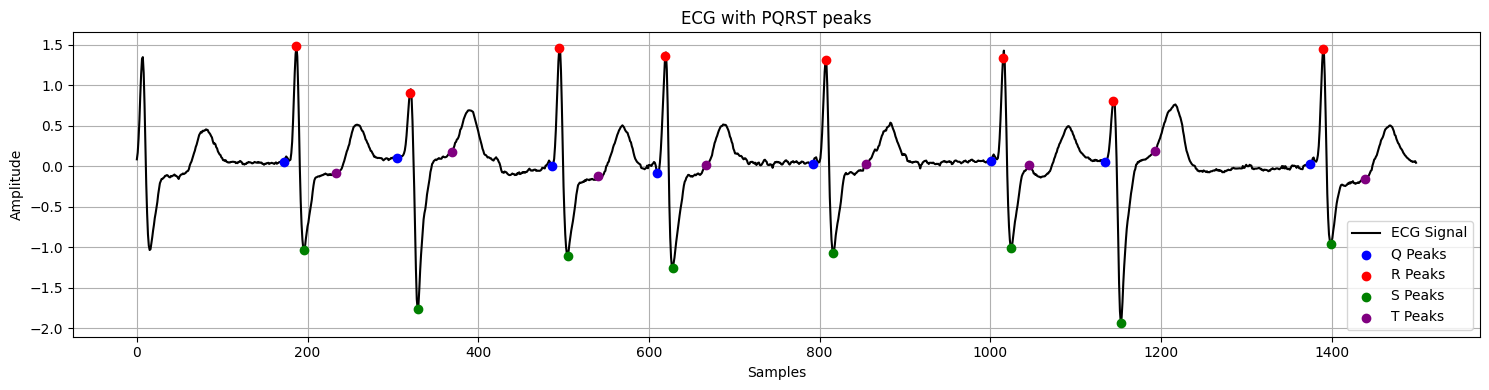

Processing the ECG: databases/cu30
ecg: 127232 [ 1.71   1.35   1.04  ... -1.75  -1.77  -1.785]


/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 7443 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


r_peaks: 252
Plotting ECG segment with peaks...


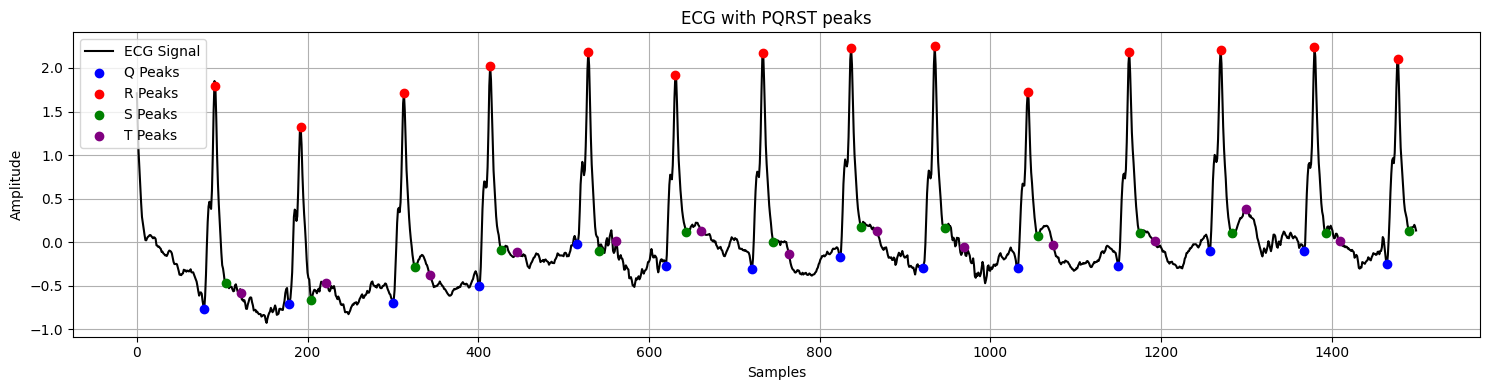

Processing the ECG: databases/cu31
ecg: 127232 [-0.1275 -0.125  -0.12   ... -0.1425 -0.21   -0.29  ]


/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 200 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


r_peaks: 294
Plotting ECG segment with peaks...


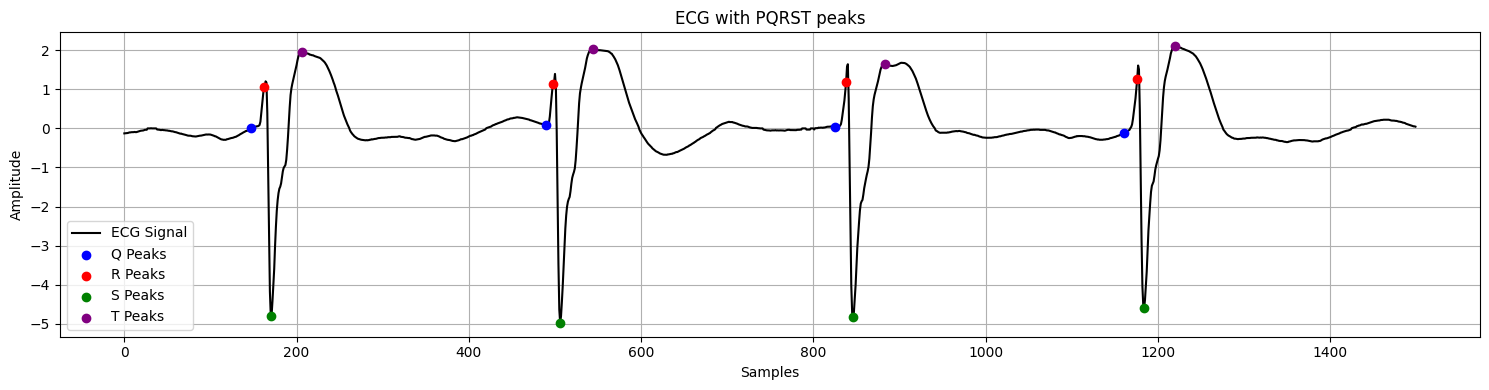

Processing the ECG: databases/cu32
ecg: 127232 [0.485  0.4825 0.47   ... 0.29   0.3    0.3175]


/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 14 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


r_peaks: 780
Plotting ECG segment with peaks...


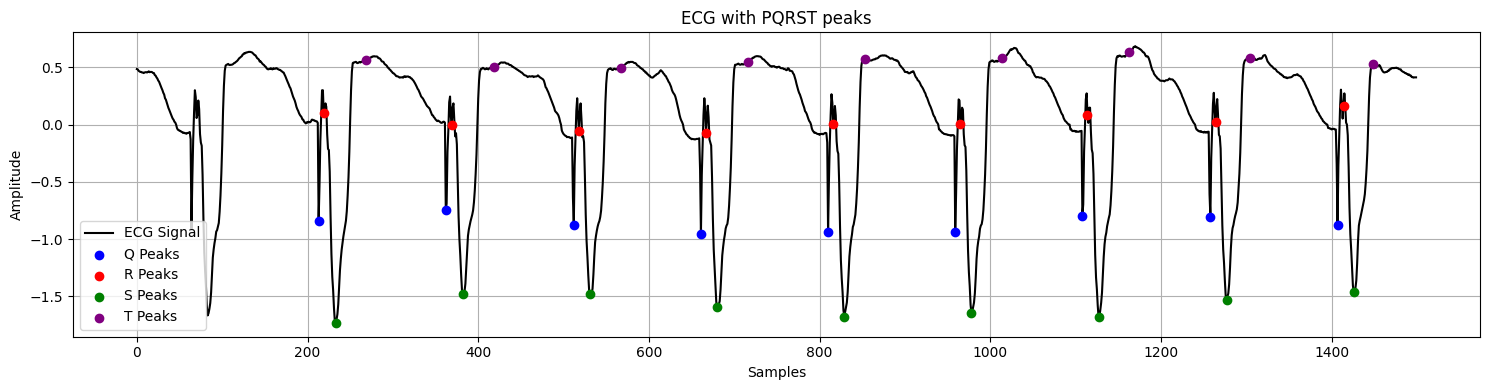

Processing the ECG: databases/cu33
ecg: 127232 [-0.44  -0.44  -0.435 ...  0.125  0.135  0.135]


/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 234 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


r_peaks: 590
Plotting ECG segment with peaks...


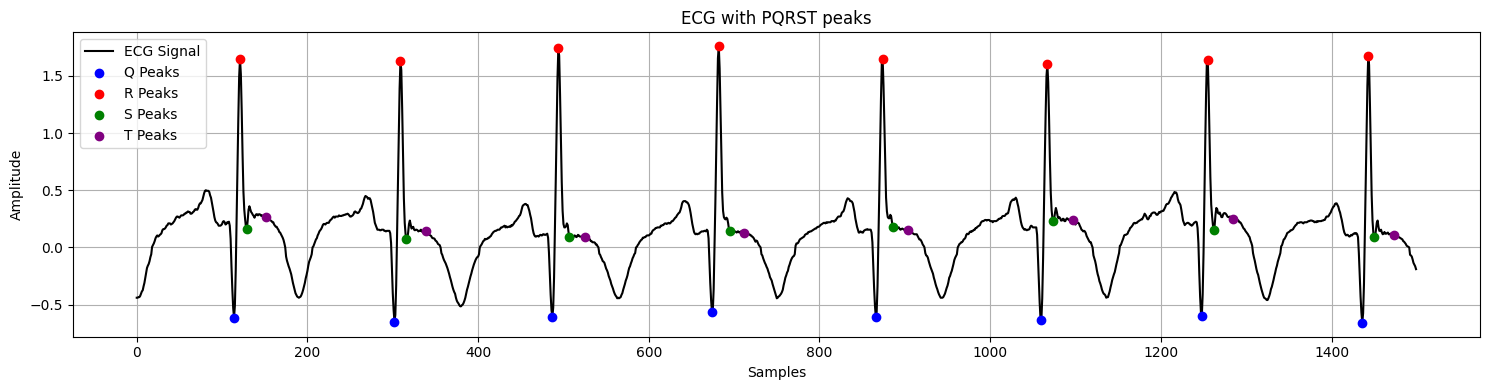

Processing the ECG: databases/cu34
ecg: 127232 [0.5475 0.545  0.5475 ... 0.8475 0.9225 0.975 ]
r_peaks: 390
Plotting ECG segment with peaks...


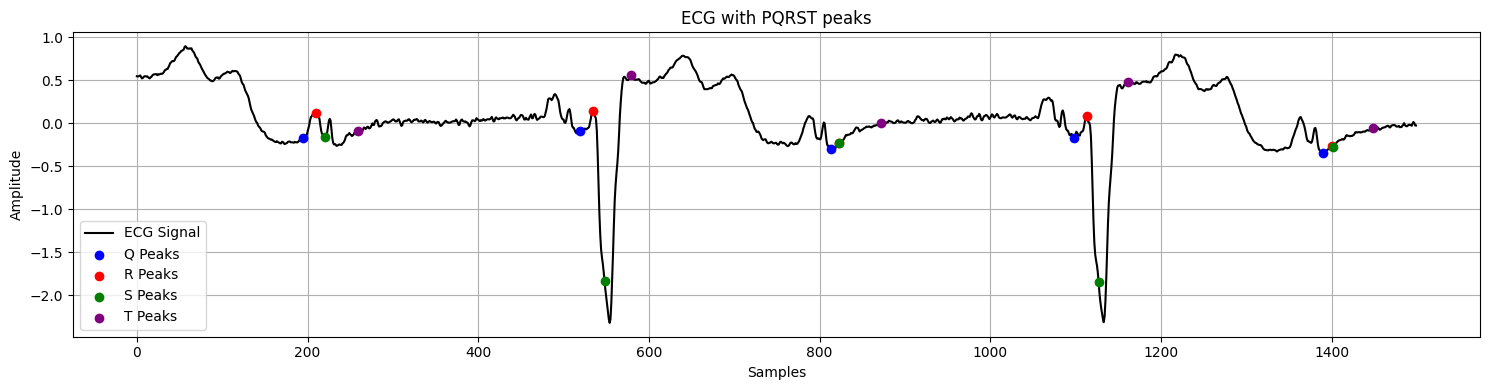

Processing the ECG: databases/cu35
ecg: 127232 [ 0.75    0.785   0.785  ... -0.0675 -0.1325 -0.17  ]


/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 576 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/zainab/Documents/LUMS RA/Work Documents/Code/ECG-Feature-Extraction-Matlab/venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


r_peaks: 488
Plotting ECG segment with peaks...


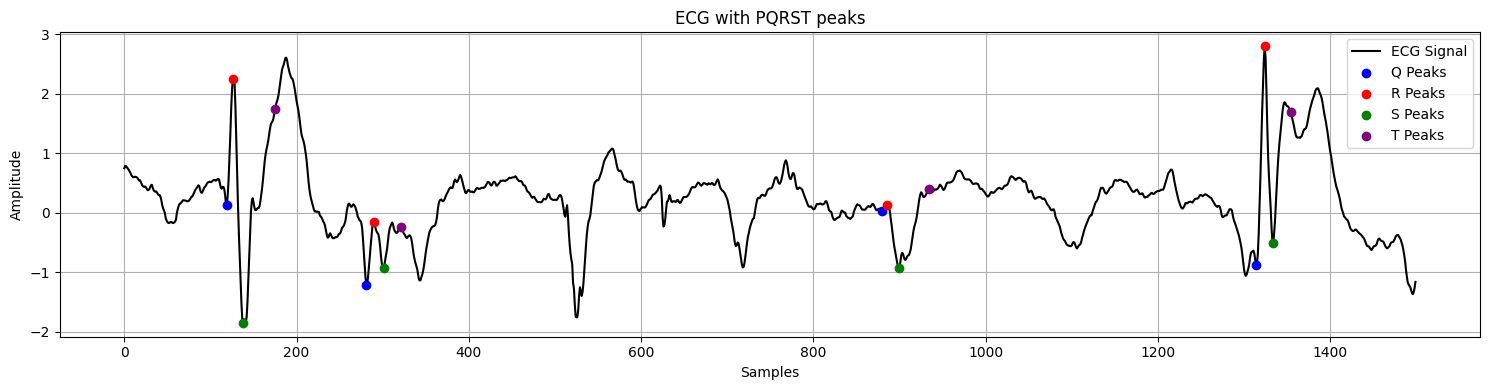

All Features: {'VT': [[np.float64(-0.275), np.float64(-0.3), np.float64(-1.9), np.float64(0.695), np.float64(0.536), np.float64(0.052)], [np.float64(-0.125), np.float64(-0.07), np.float64(-0.14), np.float64(0.41), np.float64(1.536), np.float64(0.052)], [np.float64(0.275), np.float64(0.21), np.float64(0.185), np.float64(-0.095), np.float64(1.536), np.float64(0.076)], [np.float64(-0.37), np.float64(-0.405), np.float64(-0.37), np.float64(0.505), np.float64(0.536), np.float64(0.052)], [np.float64(-0.73), np.float64(-0.745), np.float64(-0.815), np.float64(-0.755), np.float64(1.536), np.float64(0.052)], [np.float64(0.035), np.float64(0.06), np.float64(-0.035), np.float64(0.495), np.float64(1.536), np.float64(0.076)], [np.float64(-0.755), np.float64(-0.78), np.float64(-0.85), np.float64(0.385), np.float64(1.34), np.float64(0.06)], [np.float64(0.35), np.float64(0.3), np.float64(0.35), np.float64(0.165), np.float64(0.736), np.float64(0.06)], [np.float64(-0.31), np.float64(-0.42), np.float64(-0.

In [6]:
for i, filename in enumerate(file_list):
    if i < 48 or i > 82:
        continue
    record_path = os.path.join(folder, filename[:-4])
    print('Processing the ECG:', record_path)
    try:
        ecg_signal, fields = wfdb.rdsamp(record_path)
        ann = wfdb.rdann(record_path, 'atr')
    except Exception as e:
        print(f"Skipping {record_path}: {e}")
        continue

    ecg_signal = ecg_signal[:, 0]
    fs = fields['fs']
    ann_samples = ann.sample
    comments = ann.aux_note
    print('ecg:', len(ecg_signal), ecg_signal)
    # detectors = Detectors(fs)
    # try:
    #     r_peaks = np.array(detectors.pan_tompkins_detector(ecg))
    # except Exception as e:
    #     print(f"Skipping {record_path} due to Pan-Tompkins error: {e}")
    #     continue

    # implementation # 1
    import neurokit2 as nk
    try:
        signals, info = nk.ecg_process(ecg_signal, sampling_rate=fs)
        r_peaks = info["ECG_R_Peaks"]
    except Exception as e:
        print(f"Skipping {record_path}: {e}")
        continue

    # implementation # 2
    # from pan_tompkins import Pan_Tompkins_QRS, heart_rate

    # # Convert ECG signal to the required format (if needed)
    # df_ecg = pd.DataFrame({
    #     "TimeStamp": np.arange(len(ecg)),
    #     "ecg": ecg
    # })
    # # Run preprocessing
    # QRS_detector = Pan_Tompkins_QRS(filename=record_path)
    # QRS_detector.solve(df_ecg)

    # # Detect R-peaks
    # hr = heart_rate(ecg, fs)
    # r_peaks = np.array(hr.find_r_peaks())
    # r_peaks = r_peaks[r_peaks > 0]  # remove invalid indices

    # implementation # 3
    # from biosppy.signals import ecg

    # # ecg_signal: your 1D numpy array (raw ECG data)
    # # fs: sampling frequency (e.g., 360 Hz for MIT-BIH, 250 Hz for CUDB)

    # try:
    #     out = ecg.ecg(signal=ecg_signal, sampling_rate=fs, show=True)
    #     r_peaks = out['rpeaks']
    #     if len(r_peaks) < 2:
    #         print(f"Skipping {record_path}: not enough R-peaks detected ({len(r_peaks)})")
    #         continue
    # except Exception as e:
    #     print(f"Skipping {record_path} due to BioSPPy error: {e}")
    #     continue

    print('r_peaks:', len(r_peaks))

    if len(r_peaks) == 0:
        print(f"Skipping {record_path} due to empty r_peaks")
        continue

    q_peaks, s_peaks, t_peaks = [], [], []

    for r in r_peaks:
        # Q peak: ~60ms before R
        q_start = max(r - int(0.06 * fs), 0)
        q_valley = np.argmin(ecg_signal[q_start:r]) if r > q_start else 0
        q_peaks.append(q_start + q_valley)

        # S peak: ~60ms after R
        s_end = min(r + int(0.06 * fs), len(ecg_signal) - 1)
        s_valley = np.argmin(ecg_signal[r:s_end]) if s_end > r else 0
        s_peaks.append(r + s_valley)

        # T peak: 120–200ms after R
        t_start = r + int(0.12 * fs)
        t_end = r + int(0.2 * fs)
        t_start = min(t_start, len(ecg_signal) - 1)
        t_end = min(t_end, len(ecg_signal))
        if t_end > t_start:
            t_peak = np.argmax(ecg_signal[t_start:t_end])
            t_peaks.append(t_start + t_peak)

    r_peaks = np.array(r_peaks)
    q_peaks = np.array(q_peaks)
    s_peaks = np.array(s_peaks)
    t_peaks = np.array(t_peaks)

    # if filename.startswith("2") and len(ann_samples) > 100:  # e.g., 200.hea (MIT AFIB range)
    if len(ann_samples) > 100:
        print("Plotting ECG segment with peaks...")
        # plot_ecg_with_peaks(ecg, r_peaks, q_peaks, s_peaks, t_peaks,
        #                     start=ann_samples[100], end=ann_samples[100]+500,
        #                     title=filename)
        # plot_r_peaks(ecg, r_peaks, start=0, end=1500)
        plot_pqrst_peaks(ecg_signal, r_peaks, q_peaks=q_peaks, s_peaks=s_peaks, t_peaks=t_peaks, start=0, end=1500)

    # print('q_peaks:', len(q_peaks), q_peaks)
    # print('s_peaks:', len(s_peaks), s_peaks)
    # print('t_peaks:', len(t_peaks), t_peaks)
    features_by_class = extract_features(ecg_signal, ann_samples, r_peaks, q_peaks, s_peaks, t_peaks, fs, comments)
    # print('Features by class:', features_by_class)
    for cls in features_by_class:
        all_features[cls].extend(features_by_class[cls])

print('All Features:', all_features)

In [7]:
X_vt = np.array(all_features['VT'])
X_normal = np.array(all_features['N'])
# min_len = min(len(X_vt), len(X_normal))

# X_vt = X_vt[:min_len]
# X_normal = X_normal[np.random.choice(len(X_normal), min_len, replace=False)]

print(len(X_vt), len(X_normal))

X = np.vstack((X_vt, X_normal))
Y = np.array([1]*len(X_vt) + [0]*len(X_normal))

print(X)
print(Y)
print(len(X), len(Y))

16 1729
[[-0.275  -0.3    -1.9     0.695   0.536   0.052 ]
 [-0.125  -0.07   -0.14    0.41    1.536   0.052 ]
 [ 0.275   0.21    0.185  -0.095   1.536   0.076 ]
 ...
 [ 1.2625 -0.7275 -1.7025 -0.385   0.72    0.092 ]
 [ 1.59   -0.645  -1.6225 -0.2575  0.368   0.092 ]
 [ 1.6825 -0.3975 -1.495  -0.1075  0.72    0.08  ]]
[1 1 1 ... 0 0 0]
1745 1745


In [8]:
def augment_features(X, num_aug=2, noise_level=0.01):
    augmented = []
    for x in X:
        for _ in range(num_aug):
            noisy = x + np.random.normal(0, noise_level, size=x.shape)
            augmented.append(noisy)
    return np.array(augmented)

X_vt_aug = augment_features(X_vt, num_aug=100, noise_level=0.05)
Y_vt_aug = np.ones(len(X_vt_aug))

print (len(X_vt), len(X_vt_aug))
# Combine with original
X = np.vstack([X_vt, X_vt_aug, X_normal])
Y = np.array([1]*len(X_vt) + [1]*len(X_vt_aug) + [0]*len(X_normal))

print(X)
print(Y)
print(len(X), len(Y))

16 1600
[[-0.275  -0.3    -1.9     0.695   0.536   0.052 ]
 [-0.125  -0.07   -0.14    0.41    1.536   0.052 ]
 [ 0.275   0.21    0.185  -0.095   1.536   0.076 ]
 ...
 [ 1.2625 -0.7275 -1.7025 -0.385   0.72    0.092 ]
 [ 1.59   -0.645  -1.6225 -0.2575  0.368   0.092 ]
 [ 1.6825 -0.3975 -1.495  -0.1075  0.72    0.08  ]]
[1 1 1 ... 0 0 0]
3345 3345


In [9]:
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer

# Remove samples with NaNs before training
nan_mask = ~np.isnan(X).any(axis=1)
X = X[nan_mask]
Y = Y[nan_mask]

print(len(X), len(Y))

3319 3319


In [10]:
# Cross-validation
skf = StratifiedKFold(n_splits=5)
results = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}


In [11]:
for fold, (train_idx, test_idx) in enumerate(skf.split(X, Y), 1):
    print('->fold:', fold)
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    w_vt = 1 / np.sum(y_train == 1)
    w_n = 1 / np.sum(y_train == 0)
    weights = np.where(y_train == 1, w_vt, w_n)
    weights = weights * len(y_train) / np.sum(weights)

    clf = SVC(kernel='linear', probability=True)
    clf.fit(X_train, y_train, sample_weight=weights)

    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)[:, 1]

    results['accuracy'].append(accuracy_score(y_test, y_pred))
    results['precision'].append(precision_score(y_test, y_pred))
    results['recall'].append(recall_score(y_test, y_pred))
    results['f1'].append(f1_score(y_test, y_pred))
    results['auc'].append(roc_auc_score(y_test, y_score))



->fold: 1
->fold: 2
->fold: 3
->fold: 4
->fold: 5


In [12]:
for k, v in results.items():
    print(f"Mean {k}: {np.mean(v):.4f} ± {np.std(v):.4f}")


Mean accuracy: 0.6661 ± 0.2127
Mean precision: 0.6551 ± 0.2439
Mean recall: 0.6200 ± 0.3041
Mean f1: 0.6118 ± 0.2835
Mean auc: 0.7974 ± 0.1652
